# <center>Multivariate Linear Regression on House Pricing Data</center>

### <center>Source: Kaggle - House Prices: Advanced Regression Techniques
## <center>[Kaggle DataSet](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview)</center>


In [101]:
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
import seaborn as sns
from itertools import combinations
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.feature_selection import RFE
from numpy.polynomial.polynomial import polyfit
from pandas import Series
import matplotlib.pylab as plt
from statsmodels.compat import lzip

In [102]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LinearRegression


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Engineering

In [103]:
traindf = pd.read_csv('train.csv')

In [104]:
len(traindf)

1460

In [105]:
#traindf.columns

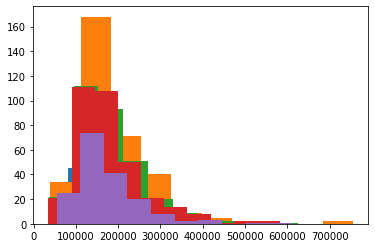

In [106]:
dates = list(traindf['YrSold'].unique())
for i in dates:
    data = traindf.loc[traindf['YrSold'] == i]
    plt.hist(data['SalePrice'])

## Add average mortgage rate data onto the existing data

In [107]:
date_dict = {'Jan':'1','Feb':'2','Mar':'3','Apr':'4','May':'5','Jun':'6',
                 'Jul':'7','Aug':'8','Sep':'9','Oct':'10','Nov':'11','Dec':'12'}

In [108]:
rate_data = open('rate_data.txt', 'r')
rate_list = []
date_list = []
for x in rate_data:
    x = x.replace('\n','')
    x = x.replace('\t',',')
    for i in date_dict.keys():
        x = x.replace(f'{i}', date_dict[f'{i}'])
    x = x.split(',')
    rate_list.append(x)
rate_list[:5]
rate_df = pd.DataFrame(rate_list, columns=['date', 'rate'])

In [109]:
date_list = []
for i in range(len(traindf)):
    date_list.append(str(traindf['MoSold'][i]) +'-' + str(traindf['YrSold'][i]))
traindf['date'] = pd.Series(date_list)

In [110]:
traindf = pd.merge(traindf, rate_df, how='inner', on='date')

In [111]:
traindf['rate'] = traindf['rate'].astype(float)
traindf.drop('date', axis=1, inplace=True)

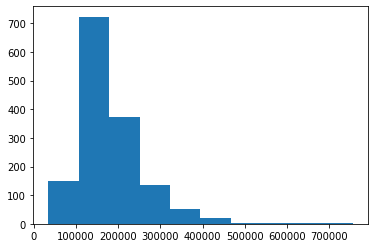

In [112]:
plt.hist(traindf['SalePrice']);

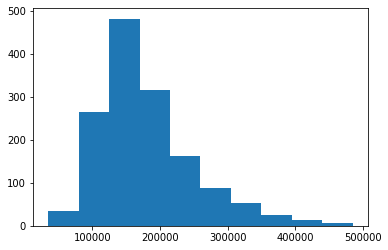

In [113]:
traindf = traindf.loc[traindf['SalePrice'] < 500000]
plt.hist(traindf['SalePrice']);

In [114]:
construction_df = pd.read_csv('New_construction.csv')
construction_df['YrSold'] = construction_df['YrSold'].astype(int)
construction_df.describe()

,YrSold,new_single_family_homes,new_multi_family buildings,new_multi_family_units
count,11.000000,11.000000,11.000000,11.000000
mean,2006.000000,142.727273,14.272727,276.000000
std,3.316625,76.706050,10.130063,188.369318
min,2001.000000,58.000000,0.000000,0.000000
25%,2003.500000,65.500000,8.000000,136.500000
50%,2006.000000,132.000000,13.000000,228.000000
75%,2008.500000,199.500000,20.000000,384.500000
max,2011.000000,264.000000,31.000000,573.000000


In [115]:
traindf = pd.merge(traindf, construction_df)
traindf

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,rate,new_single_family_homes,new_multi_family buildings,new_multi_family_units
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,2,2008,WD,Normal,208500,6.409,70,11,201
1,11,20,RL,70.0,11200,Pave,NaN,Reg,Lvl,AllPub,...,0,2,2008,WD,Normal,129500,6.409,70,11,201
2,202,20,RL,75.0,10125,Pave,NaN,Reg,Lvl,AllPub,...,0,2,2008,WD,Normal,171500,6.409,70,11,201
3,269,30,RM,71.0,6900,Pave,NaN,Reg,Lvl,AllPub,...,0,2,2008,WD,Normal,120500,6.409,70,11,201
4,423,20,RL,100.0,21750,Pave,NaN,Reg,HLS,AllPub,...,0,2,2008,WD,Normal,113000,6.409,70,11,201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1446,1323,60,RL,107.0,10186,Pave,NaN,IR1,Lvl,AllPub,...,0,6,2010,WD,Normal,190000,5.130,58,3,95
1447,1359,160,FV,NaN,2117,Pave,NaN,Reg,Lvl,AllPub,...,0,6,2010,WD,Normal,177500,5.130,58,3,95
1448,1381,30,RL,45.0,8212,Pave,Grvl,Reg,Lvl,AllPub,...,0,6,2010,WD,Normal,58500,5.130,58,3,95
1449,1397,20,RL,NaN,57200,Pave,NaN,IR1,Bnk,AllPub,...,0,6,2010,WD,Normal,160000,5.130,58,3,95


#### Removing data with more than 30% NAN values 

In [116]:
drop_list = ['Exterior2nd', 'YearRemodAdd', 'LotShape', 'MSSubClass', 'TotalBsmtSF', 'Alley', 'GarageYrBlt', 'PoolQC', 'MiscFeature', 'MiscFeature']

#### Moving Sale Price over to targetdf

In [117]:
targetdf = traindf[['Id', 'SalePrice']]
traindf.drop('SalePrice', axis=1, inplace=True)

#### Removing problematic columns

In [118]:
traindf = traindf.drop(drop_list, axis=1)

#### Seperating the catagorical and numerical data

In [119]:
traindf_cat = traindf[['Id', 'MSZoning']].copy()
traindf.drop('MSZoning', axis=1, inplace=True)

In [120]:
lotfront = traindf.LotFrontage.mean()

### Replacing NA values with the mean value for the column

In [121]:
traindf.LotFrontage.fillna(value=lotfront, inplace=True)

In [122]:
traindf_cat.FireplaceQu = traindf.FireplaceQu
traindf_cat.FireplaceQu.fillna(value='None', inplace=True)
traindf.drop('FireplaceQu', axis = 1, inplace=True)

In [123]:
traindf_cat['Street'] = traindf.Street
traindf.drop('Street', axis=1, inplace=True)

In [124]:
traindf_cat['LandContour'] = traindf.LandContour
traindf.drop('LandContour', axis=1, inplace=True)

In [125]:
traindf_cat['Utilities'] = traindf.Utilities
traindf.drop('Utilities', axis=1, inplace=True)

In [126]:
traindf_cat['LotConfig'] = traindf.LotConfig
traindf.drop('LotConfig', axis=1, inplace=True)

In [127]:
traindf_cat['LandSlope'] = traindf.LandSlope
traindf.drop('LandSlope', axis=1, inplace=True)

In [128]:
traindf_cat['Neighborhood'] = traindf.Neighborhood
traindf.drop('Neighborhood', axis=1, inplace=True)

In [129]:
traindf_cat['Condition1'] = traindf.Condition1
traindf.drop('Condition1', axis=1, inplace=True)

traindf_cat['Condition2'] = traindf.Condition2
traindf.drop('Condition2', axis=1, inplace=True)

In [130]:
traindf_cat['BldgType'] = traindf.BldgType
traindf.drop('BldgType', axis=1, inplace=True)

In [131]:
traindf_cat['HouseStyle'] = traindf.HouseStyle
traindf.drop('HouseStyle', axis=1, inplace=True)

In [132]:
traindf_cat['RoofStyle'] = traindf.RoofStyle
traindf.drop('RoofStyle', axis=1, inplace=True)

In [133]:
traindf_cat['RoofMatl'] = traindf.RoofMatl
traindf.drop('RoofMatl', axis=1, inplace=True)

In [134]:
traindf_cat['Exterior1st'] = traindf.Exterior1st
traindf.drop('Exterior1st', axis=1, inplace=True)

#traindf_cat['Exterior2nd'] = traindf.Exterior2nd
#traindf.drop('Exterior2nd', axis=1, inplace=True)

In [135]:
traindf.MasVnrType.fillna(value='None', inplace=True)
traindf_cat['MasVnrType'] = traindf.MasVnrType
traindf.drop('MasVnrType', axis=1, inplace=True)

In [136]:
traindf_cat.ExterQual = traindf.ExterQual
traindf.drop('ExterQual', axis=1, inplace=True)

In [137]:
traindf_cat.ExterCond = traindf.ExterCond 
traindf.drop('ExterCond', axis=1, inplace=True)

In [138]:
traindf_cat['Foundation'] = traindf.Foundation
traindf.drop('Foundation', axis=1, inplace=True)

In [139]:
traindf.MasVnrArea.fillna(value=0.00, inplace=True) 

In [140]:
traindf_cat.BsmtCond = traindf.BsmtCond
traindf.drop('BsmtCond', axis=1, inplace=True)

In [141]:
traindf_cat.BsmtFinType1 = traindf.BsmtFinType1
traindf.drop('BsmtFinType1', axis=1, inplace=True)

In [142]:
traindf_cat.BsmtExposure = traindf.BsmtExposure
traindf.drop('BsmtExposure', axis=1, inplace=True)

In [143]:
traindf_cat.BsmtQual = traindf.BsmtQual
traindf.drop('BsmtQual',axis=1, inplace=True)

In [144]:
traindf_cat.BsmtFinType2 = traindf.BsmtFinType2
traindf.drop('BsmtFinType2', axis=1, inplace=True)

In [145]:
traindf_cat['Heating'] = traindf.Heating
traindf.drop('Heating', axis=1, inplace=True)

In [146]:
traindf.HeatingQC = traindf.HeatingQC
traindf.drop('HeatingQC', axis=1, inplace=True)

In [147]:
traindf_cat['CentralAir'] = traindf.CentralAir
traindf.drop('CentralAir', axis=1, inplace=True)

In [148]:
traindf_cat['Electrical'] = traindf.Electrical
traindf.drop('Electrical', axis=1, inplace=True)
traindf_cat.Electrical.fillna(value='None', inplace=True)

In [149]:
traindf_cat.KitchenQual = traindf.KitchenQual
traindf.drop('KitchenQual', axis=1, inplace=True)

In [150]:
traindf_cat['Functional'] = traindf.Functional
traindf.drop('Functional', axis=1, inplace=True)

In [151]:
traindf_cat['GarageType'] = traindf.GarageType
traindf.drop('GarageType', axis=1, inplace=True)
traindf_cat.GarageType.fillna(value='NoGarage', inplace=True)

In [152]:
traindf_cat.GarageFinish = traindf.GarageFinish
traindf.drop('GarageFinish', axis=1, inplace=True)

In [153]:
traindf_cat.GarageQual = traindf.GarageQual
traindf.drop('GarageQual', axis=1, inplace=True)

In [154]:
traindf_cat.GarageCond = traindf.GarageCond
traindf.drop('GarageCond',axis=1, inplace=True)

In [155]:
traindf_cat['PavedDrive'] = traindf.PavedDrive
traindf.drop('PavedDrive', axis=1, inplace=True)

In [156]:
traindf_cat['Fence'] = traindf.Fence
traindf.drop('Fence', axis=1, inplace=True)
traindf_cat.fillna(value='NoFence', inplace=True)

In [157]:
traindf_cat['MoSold'] = traindf.MoSold
traindf.drop('MoSold', axis=1, inplace=True)

In [158]:
traindf_cat['SaleType'] = traindf.SaleType
traindf.drop('SaleType', axis=1, inplace=True)

In [159]:
traindf_cat['SaleCondition'] = traindf.SaleCondition
traindf.drop('SaleCondition', axis=1, inplace=True)

In [160]:
traindf_cat['BsmtFullBath'] = traindf.BsmtFullBath
traindf.drop('BsmtFullBath', axis=1, inplace=True)

In [161]:
traindf_cat['BsmtHalfBath'] = traindf.BsmtHalfBath
traindf.drop('BsmtHalfBath', axis=1, inplace=True)

In [162]:
traindf_cat['FullBath'] = traindf.FullBath
traindf.drop('FullBath', axis=1, inplace=True)

In [163]:
traindf_cat['HalfBath'] = traindf.HalfBath
traindf.drop('HalfBath', axis=1, inplace=True)

In [164]:
traindf_cat['BedroomAbvGr'] = traindf.BedroomAbvGr
traindf.drop('BedroomAbvGr', axis=1, inplace=True)

In [165]:
traindf_cat['KitchenAbvGr'] = traindf.KitchenAbvGr
traindf.drop('KitchenAbvGr', axis=1, inplace=True)

In [166]:
traindf_cat['TotRmsAbvGrd'] = traindf.TotRmsAbvGrd
traindf.drop('TotRmsAbvGrd', axis=1, inplace=True)

In [167]:
traindf_cat['Fireplaces'] = traindf.Fireplaces
traindf.drop('Fireplaces', axis=1, inplace=True)

In [168]:
traindf_cat['GarageCars'] = traindf.GarageCars
traindf.drop('GarageCars', axis=1, inplace=True)

In [169]:
traindf['ThreeSsnPorch'] = traindf['3SsnPorch']
traindf.drop('3SsnPorch', axis=1, inplace=True)

In [170]:
traindf['FirstFlrSF'] = traindf['1stFlrSF']
traindf.drop('1stFlrSF', axis=1, inplace=True)

In [171]:
traindf['SecondFlrSF'] = traindf['2ndFlrSF']
traindf.drop('2ndFlrSF', axis=1, inplace=True)

## Feature Scaling - Apply Box-Cox?
### Box-Cox did not improve the model

In [172]:
traindf_cat.shape

(1451, 36)

In [173]:
traindf_columns = traindf.columns

In [174]:
traindf.describe()

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,PoolArea,MiscVal,YrSold,rate,new_single_family_homes,new_multi_family buildings,new_multi_family_units,ThreeSsnPorch,FirstFlrSF,SecondFlrSF
count,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,...,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000
mean,730.079256,69.833054,10442.747760,6.079256,5.578222,1971.071675,99.972433,437.809097,46.466575,566.076499,...,2.393522,43.758787,2007.813921,6.257787,98.904204,6.809786,128.605789,3.430737,1156.673329,342.745003
std,422.163067,21.842884,9916.673175,1.362524,1.115370,30.189728,173.498236,447.757832,161.264463,440.565397,...,37.599673,497.648467,1.326587,0.597619,41.405478,4.951733,84.948701,29.406940,379.591002,429.825177
min,1.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2006.000000,4.957000,58.000000,0.000000,0.000000,0.000000,334.000000,0.000000
25%,364.500000,60.000000,7517.500000,5.000000,5.000000,1954.000000,0.000000,0.000000,0.000000,222.000000,...,0.000000,0.000000,2007.000000,5.678000,61.000000,3.000000,95.000000,0.000000,882.000000,0.000000
50%,729.000000,69.833054,9452.000000,6.000000,5.000000,1972.000000,0.000000,381.000000,0.000000,476.000000,...,0.000000,0.000000,2008.000000,6.476000,70.000000,6.000000,116.000000,0.000000,1085.000000,0.000000
75%,1095.500000,78.500000,11506.000000,7.000000,6.000000,2000.000000,160.500000,705.500000,0.000000,808.000000,...,0.000000,0.000000,2009.000000,6.825000,127.000000,11.000000,201.000000,0.000000,1382.500000,728.000000
max,1460.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,...,738.000000,15500.000000,2010.000000,7.008000,161.000000,13.000000,228.000000,508.000000,4692.000000,1818.000000


In [175]:
#traindf = traindf + 1
traindf.min()

Id                                1.000
LotFrontage                      21.000
LotArea                        1300.000
OverallQual                       1.000
OverallCond                       1.000
YearBuilt                      1872.000
MasVnrArea                        0.000
BsmtFinSF1                        0.000
BsmtFinSF2                        0.000
BsmtUnfSF                         0.000
LowQualFinSF                      0.000
GrLivArea                       334.000
GarageArea                        0.000
WoodDeckSF                        0.000
OpenPorchSF                       0.000
EnclosedPorch                     0.000
ScreenPorch                       0.000
PoolArea                          0.000
MiscVal                           0.000
YrSold                         2006.000
rate                              4.957
 new_single_family_homes         58.000
 new_multi_family buildings       0.000
 new_multi_family_units           0.000
ThreeSsnPorch                     0.000


In [176]:
import scipy.stats
low_vals = []
box = ['LotArea', 'OverallCond', 'YearBuilt', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'YrSold', 'ThreeSsnPorch', 'FirstFlrSF', 'SecondFlrSF']
box1 = 'OverallCond'
for ox in box:
    print(f"traindf['{ox}'] = stats.boxcox(traindf['{ox}'])[0]")
    print(traindf[f'{ox}'].min(), ox)

traindf['LotArea'] = stats.boxcox(traindf['LotArea'])[0]
1300 LotArea
traindf['OverallCond'] = stats.boxcox(traindf['OverallCond'])[0]
1 OverallCond
traindf['YearBuilt'] = stats.boxcox(traindf['YearBuilt'])[0]
1872 YearBuilt
traindf['MasVnrArea'] = stats.boxcox(traindf['MasVnrArea'])[0]
0.0 MasVnrArea
traindf['BsmtFinSF1'] = stats.boxcox(traindf['BsmtFinSF1'])[0]
0 BsmtFinSF1
traindf['BsmtFinSF2'] = stats.boxcox(traindf['BsmtFinSF2'])[0]
0 BsmtFinSF2
traindf['BsmtUnfSF'] = stats.boxcox(traindf['BsmtUnfSF'])[0]
0 BsmtUnfSF
traindf['WoodDeckSF'] = stats.boxcox(traindf['WoodDeckSF'])[0]
0 WoodDeckSF
traindf['OpenPorchSF'] = stats.boxcox(traindf['OpenPorchSF'])[0]
0 OpenPorchSF
traindf['EnclosedPorch'] = stats.boxcox(traindf['EnclosedPorch'])[0]
0 EnclosedPorch
traindf['ScreenPorch'] = stats.boxcox(traindf['ScreenPorch'])[0]
0 ScreenPorch
traindf['PoolArea'] = stats.boxcox(traindf['PoolArea'])[0]
0 PoolArea
traindf['MiscVal'] = stats.boxcox(traindf['MiscVal'])[0]
0 MiscVal
traindf['YrSold'

In [177]:
#traindf['LotArea'] = stats.boxcox(traindf['LotArea'])[0]
#traindf['YearBuilt'] = stats.boxcox(traindf['YearBuilt'])[0]
#traindf['OverallCond'] = stats.boxcox(traindf['OverallCond'])[0]
#traindf['MasVnrArea'] = stats.boxcox(traindf['MasVnrArea'])[0]
#traindf['BsmtFinSF1'] = stats.boxcox(traindf['BsmtFinSF1'])[0]
#traindf['BsmtFinSF2'] = stats.boxcox(traindf['BsmtFinSF2'])[0]
#traindf['BsmtUnfSF'] = stats.boxcox(traindf['BsmtUnfSF'])[0]
#traindf['WoodDeckSF'] = stats.boxcox(traindf['WoodDeckSF'])[0]
#traindf['OpenPorchSF'] = stats.boxcox(traindf['OpenPorchSF'])[0]
#traindf['EnclosedPorch'] = stats.boxcox(traindf['EnclosedPorch'])[0]
#traindf['ScreenPorch'] = stats.boxcox(traindf['ScreenPorch'])[0]
#traindf['PoolArea'] = stats.boxcox(traindf['PoolArea'])[0]
#traindf['MiscVal'] = stats.boxcox(traindf['MiscVal'])[0]
#traindf['YrSold'] = stats.boxcox(traindf['YrSold'])[0]
#traindf['ThreeSsnPorch'] =x stats.boxcox(traindf['ThreeSsnPorch'])[0]
#traindf['FirstFlrSF'] = stats.boxcox(traindf['FirstFlrSF'])[0]
#traindf['SecondFlrSF'] = stats.boxcox(traindf['SecondFlrSF'])[0]

In [178]:
#x = traindf['MasVnrArea'].replace(0, 'nan')
#l = stats.boxcox(x.dropna())[1]


In [179]:
#traindf['MasVnrArea'] = stats.boxcox(traindf['MasVnrArea'])[0]
traindf.describe()

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,PoolArea,MiscVal,YrSold,rate,new_single_family_homes,new_multi_family buildings,new_multi_family_units,ThreeSsnPorch,FirstFlrSF,SecondFlrSF
count,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,...,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000
mean,730.079256,69.833054,10442.747760,6.079256,5.578222,1971.071675,99.972433,437.809097,46.466575,566.076499,...,2.393522,43.758787,2007.813921,6.257787,98.904204,6.809786,128.605789,3.430737,1156.673329,342.745003
std,422.163067,21.842884,9916.673175,1.362524,1.115370,30.189728,173.498236,447.757832,161.264463,440.565397,...,37.599673,497.648467,1.326587,0.597619,41.405478,4.951733,84.948701,29.406940,379.591002,429.825177
min,1.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2006.000000,4.957000,58.000000,0.000000,0.000000,0.000000,334.000000,0.000000
25%,364.500000,60.000000,7517.500000,5.000000,5.000000,1954.000000,0.000000,0.000000,0.000000,222.000000,...,0.000000,0.000000,2007.000000,5.678000,61.000000,3.000000,95.000000,0.000000,882.000000,0.000000
50%,729.000000,69.833054,9452.000000,6.000000,5.000000,1972.000000,0.000000,381.000000,0.000000,476.000000,...,0.000000,0.000000,2008.000000,6.476000,70.000000,6.000000,116.000000,0.000000,1085.000000,0.000000
75%,1095.500000,78.500000,11506.000000,7.000000,6.000000,2000.000000,160.500000,705.500000,0.000000,808.000000,...,0.000000,0.000000,2009.000000,6.825000,127.000000,11.000000,201.000000,0.000000,1382.500000,728.000000
max,1460.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,...,738.000000,15500.000000,2010.000000,7.008000,161.000000,13.000000,228.000000,508.000000,4692.000000,1818.000000


In [180]:
from sklearn.preprocessing import StandardScaler
from scipy import stats

ss = StandardScaler()

traindfss = pd.DataFrame(ss.fit_transform(traindf))
traindfss.set_index(traindf.Id, inplace=True)
traindfss.columns = traindf_columns 
# Remove outliers, i.e. data points outside of 2 standard deviations of the mean
traindfss = traindfss[(np.abs(stats.zscore(traindfss)) < 2).all(axis=1)]
#X_train_numeric.head()

In [181]:
traindfss.drop('Id', axis=1, inplace=True)

In [182]:
traindfss.describe()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,LowQualFinSF,...,PoolArea,MiscVal,YrSold,rate,new_single_family_homes,new_multi_family buildings,new_multi_family_units,ThreeSsnPorch,FirstFlrSF,SecondFlrSF
count,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,...,6.710000e+02,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000
mean,-0.124084,-0.125052,-0.085542,-0.132308,0.183104,-0.203927,-0.018082,-0.225772,-0.074196,-0.114109,...,-6.367999e-02,-0.059580,-0.010273,-0.008594,0.018697,0.020965,0.022157,-0.115538,-0.223880,-0.076174
std,0.629895,0.348166,0.813246,0.666966,0.877777,0.603891,0.849301,0.294046,0.854529,0.098785,...,2.083221e-16,0.173798,1.020566,1.006203,1.016729,1.009703,1.005844,0.030204,0.705254,0.909955
min,-1.824246,-0.854285,-1.526558,-1.415464,-1.924221,-0.576415,-0.978118,-0.288238,-1.285329,-0.120619,...,-6.367999e-02,-0.087961,-1.367831,-1.887785,-0.988234,-1.375707,-1.514445,-0.116704,-1.677840,-0.797681
25%,-0.450327,-0.325801,-0.792373,-0.518592,-0.466269,-0.576415,-0.978118,-0.288238,-0.752875,-0.120619,...,-6.367999e-02,-0.087961,-0.613757,-0.970496,-0.915755,-0.769650,-0.395737,-0.116704,-0.771289,-0.797681
50%,0.000000,-0.152598,-0.058188,-0.518592,0.229572,-0.576415,0.009363,-0.288238,-0.243127,-0.120619,...,-6.367999e-02,-0.087961,0.140317,0.346850,-0.698317,-0.163592,-0.148444,-0.116704,-0.307472,-0.797681
75%,0.236632,0.032205,0.675997,0.378281,1.057954,0.046285,0.596937,-0.288238,0.505033,-0.120619,...,-6.367999e-02,-0.087961,0.894391,0.949449,0.678787,0.846503,0.852505,-0.116704,0.244628,0.858214
max,1.793740,1.968703,1.410181,1.275154,1.256765,1.972040,1.997730,1.957296,1.975242,1.520246,...,-6.367999e-02,1.319139,1.648465,1.255769,1.500217,1.250542,1.170453,0.665694,1.885117,1.981151


In [183]:
#sns.pairplot(traindf)

## Getting dummies

In [184]:
traindf_cat.Exterior1st.unique()

array(['VinylSd', 'HdBoard', 'Plywood', 'Stucco', 'Wd Sdng', 'MetalSd',
       'BrkFace', 'CemntBd', 'AsbShng', 'Stone', 'WdShing', 'ImStucc',
       'CBlock', 'BrkComm', 'AsphShn'], dtype=object)

In [185]:
traindf_cat.HouseStyle= traindf_cat.HouseStyle.replace({'1.5Fin': '1.5_Fin', '1.5Unf': '1_5Unf', '2.5Unf':'2_5Unf', '2.5Fin':'2_5Fin'}, value=None)

In [186]:
traindf_cat.Exterior1st= traindf_cat.Exterior1st.replace({'Wd Sdng': 'Wd_Sdng'}, value=None)

In [187]:
traindf_cat.RoofMatl= traindf_cat.RoofMatl.replace({'Tar&Grv': 'TarGrv'}, value=None)

In [188]:
cat_list = list(traindf_cat.columns)[1:]

In [189]:
traindf_cat_bined= pd.get_dummies(traindf_cat, columns=cat_list, drop_first=True)
#traindf_cat_bined = traindf_cat_bined.astype('object')
#traindf_cat_bined['Id'] = traindf_cat_bined['Id'].astype('int64')

In [190]:
traindf_cat_bined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1451 entries, 0 to 1450
Columns: 191 entries, Id to GarageCars_4
dtypes: int64(1), uint8(190)
memory usage: 291.9 KB


In [191]:
columnfixlist = [traindf_cat_bined.columns[i] for i in range(len(traindf_cat_bined.columns))]
#columnfixlist

In [192]:
train_combined = pd.merge(traindf_cat_bined, traindfss, on='Id', left_index=True, right_index=True)

In [193]:
targetdf = targetdf.loc[train_combined.index]

In [194]:
targetdf.head()

,Id,SalePrice
0,1,208500
1,11,129500
2,202,171500
3,269,120500
4,423,113000


In [195]:
train_combined.drop('Id', axis=1, inplace=True)

In [196]:
targetdf.set_index('Id', inplace=True)

In [197]:
targetdf.head()

,SalePrice
Id,
1,208500
11,129500
202,171500
269,120500
423,113000


## Testing for colinearity amonst columns

### Function for testing for intercorrelation - without looking at pairplots...

In [198]:
def test_colinear(train_combined):
    col_names = list(train_combined.columns)
    
    colinear = []
    for ax1 in col_names:
        for ax2 in col_names:
            try:
                if ax1 == ax2:
                    break
                else:
                    if train_combined[f'{ax1}'].corr(train_combined[f'{ax2}']) >= .75:
                        colinear.append((ax1,ax2))
            except:
                continue
    return colinear

## Attempting to use Linear Regression without ridge, lasso, or elastic net

In [199]:
test_colinear(train_combined)

[('Neighborhood_Somerst', 'MSZoning_FV'),
 ('RoofStyle_Shed', 'Condition2_RRAe'),
 ('SaleCondition_Partial', 'SaleType_New'),
 ('KitchenAbvGr_2', 'BldgType_Duplex'),
 ('TotRmsAbvGrd_14', 'BedroomAbvGr_8'),
 (' new_multi_family buildings', 'rate'),
 (' new_multi_family_units', ' new_multi_family buildings'),
 ('SecondFlrSF', 'GrLivArea')]

In [200]:
corr_saleprice = {}
least_impact = []

for i, k in test_colinear(train_combined):
    corr_saleprice[i] = train_combined[f'{i}'].corr(targetdf['SalePrice'])
    corr_saleprice[k] = train_combined[f'{k}'].corr(targetdf['SalePrice'])
    if abs(corr_saleprice[i]) > abs(corr_saleprice[k]):
        least_impact.append(k)
    else:
        least_impact.append(i)
        
print(least_impact)
corr_saleprice

['MSZoning_FV', 'RoofStyle_Shed', 'SaleType_New', 'KitchenAbvGr_2', 'TotRmsAbvGrd_14', ' new_multi_family buildings', ' new_multi_family_units', 'GrLivArea']


{'Neighborhood_Somerst': -0.03758519913086953,
 'MSZoning_FV': 0.0031801625918678384,
 'RoofStyle_Shed': nan,
 'Condition2_RRAe': nan,
 'SaleCondition_Partial': -0.05432869980602748,
 'SaleType_New': -0.048122178657602724,
 'KitchenAbvGr_2': -0.061818427362135414,
 'BldgType_Duplex': -0.06430306484538356,
 'TotRmsAbvGrd_14': nan,
 'BedroomAbvGr_8': nan,
 ' new_multi_family buildings': 0.05590894000469068,
 'rate': 0.05882756976542375,
 ' new_multi_family_units': 0.04791408789909274,
 'SecondFlrSF': 0.08891816964721225,
 'GrLivArea': 0.04204711930647875}

In [201]:
train_combined.drop(least_impact, axis=1, inplace=True)

In [202]:
from sklearn.model_selection import train_test_split
X = train_combined
y = targetdf

# Train-test split, then "set aside" test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)

In [203]:
X_train

,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,LotConfig_CulDSac,LotConfig_FR2,...,EnclosedPorch,ScreenPorch,PoolArea,MiscVal,YrSold,rate,new_single_family_homes,ThreeSsnPorch,FirstFlrSF,SecondFlrSF
14,0,0,1,1,0,0,1,0,0,0,...,-0.360582,-0.266797,-0.06368,-0.087961,0.140317,-0.389658,-0.698317,-0.116704,-0.402343,1.175895
172,0,1,0,1,0,0,1,0,0,0,...,-0.360582,-0.266797,-0.06368,-0.087961,-0.613757,1.193836,0.678787,-0.116704,0.335547,1.262006
476,0,1,0,1,0,0,1,0,1,0,...,-0.360582,0.456223,-0.06368,-0.087961,0.894391,-1.313642,-0.915755,-0.116704,-0.539380,-0.797681
143,0,1,0,1,0,0,1,0,0,0,...,-0.360582,-0.266797,-0.06368,-0.087961,-0.613757,0.211266,0.678787,-0.116704,-0.028128,-0.797681
646,0,1,0,1,0,0,1,0,0,0,...,-0.360582,-0.266797,-0.06368,-0.087961,1.648465,-1.442531,-0.988234,-0.116704,1.194662,-0.797681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,0,1,0,1,0,0,1,0,0,0,...,-0.360582,-0.266797,-0.06368,-0.087961,1.648465,-1.887785,-0.988234,-0.116704,-0.252130,1.208477
439,0,1,0,1,0,0,1,0,0,0,...,-0.360582,1.540752,-0.06368,-0.087961,0.894391,-1.434162,-0.915755,-0.116704,0.809905,-0.797681
605,0,1,0,1,0,0,1,0,0,0,...,-0.360582,-0.266797,-0.06368,-0.087961,1.648465,-1.700310,-0.988234,-0.116704,-0.644793,-0.797681
525,0,1,0,1,0,0,1,0,0,0,...,-0.360582,-0.266797,-0.06368,-0.087961,0.894391,-0.562069,-0.915755,-0.116704,1.495089,-0.797681


### Testing the linear regression ---- Too many features ---- Use Lasso or Elastic Net


In [204]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_hat = lr.predict(X_test)

In [205]:
y_hatpd = pd.DataFrame(y_hat, columns = ['SalePrice'], index = [i for i in range(len(y_hat))])

In [206]:
from sklearn.metrics import r2_score, mean_squared_error 


print(f"intercept: {lr.intercept_}")
print(f"r^2: {lr.score(X_test,y_test)}")
print(f"rmse: {np.sqrt(mean_squared_error(y_test, y_hat))}")

intercept: [1.12875601e+17]
r^2: -1.712728046938416e+21
rmse: 3155034281930922.0


In [207]:
 ### Previous R^2 values ###


### Added Rooms, Car garage, fireplaces and some other continuous/discrete values to the catagorical side of the table... increased features
### by approx 30 --- need to check R^2 adj 
# r^2: 0.898540213574302
# rmse: 25772.696681156067

### Replaced lot frontage with mean value instead of '0'
# r^2: 0.8175929129184736
# rmse: 34972.641412123485


### Initial R^2 to beat
# r^2: 0.6589675323
# rmse: 36779.91592177666

In [208]:
import statsmodels.formula.api as sm
import statsmodels.tools as smtools
#train_combined_string = ''
#for i in [train_combined.columns[i] for i in range(len(train_combined.columns))]:
 #   train_combined_string += i + ' + ' 
#train_combined_string = train_combined_string[0:-3]


#train_combined_withc = smtools.add_constant(train_combined)
#sm_formula = ("SalePrice ~ " + train_combined_string ) 
#ols_data = pd.merge(targetdf, train_combined_withc, left_index=True, right_index=True)

#results = sm.ols(formula = sm_formula,data = ols_data).fit()

# Lasso Regression

In [209]:
import statsmodels.tools.tools as smtools
train_combined_withc = smtools.add_constant(train_combined)

In [210]:
from sklearn.model_selection import train_test_split
X = train_combined_withc
y = targetdf

# Train-test split, then "set aside" test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1)

### Arbitrary Alpha = .5 Lasso Regression

In [211]:
Lassoreg = Lasso(alpha= .5, max_iter = 1000000000, normalize = False)
Lassoreg.fit(X_train, y_train)
L_target_prediction = Lassoreg.predict(X_test)

print(f'R2 on test: {Lassoreg.score(X_test, y_test)},\nR2 on all: {Lassoreg.score(X,y)}')


R2 on test: 0.5200186917671132,
R2 on all: 0.8622472785133917


The difference in the R2 is not significant enough to warrent overfitting this model decent. 

Can we optimize alpha?

# Optimizing alpha term

[(0.5, 0.8881264891704683, 0.7309875955524678),
 (0.5344827586206896, 0.8881237022079507, 0.7309808939885103),
 (0.5689655172413793, 0.888120730294786, 0.730973747689978),
 (0.603448275862069, 0.8881184375576054, 0.7316243940578051),
 (0.6379310344827587, 0.8881163154065708, 0.7316193035535486),
 (0.6724137931034483, 0.8881140757025409, 0.7316139310693517),
 (0.7068965517241379, 0.8881117181163385, 0.7316082758156011),
 (0.7413793103448276, 0.8881091873815359, 0.7312747847573289),
 (0.7758620689655172, 0.8881057098760561, 0.7315938635649029),
 (0.8103448275862069, 0.8881020821300522, 0.7315851615186428),
 (0.8448275862068966, 0.8880983011574507, 0.7319021798563923),
 (0.8793103448275862, 0.8880943732762734, 0.7318927693077384),
 (0.9137931034482758, 0.8880902885968942, 0.7318829830967257),
 (0.9482758620689655, 0.8880860469016314, 0.7318728207018252),
 (0.9827586206896551, 0.8880816482132221, 0.7318622821775114),
 (1.0172413793103448, 0.8880770925973632, 0.7318513676811828),
 (1.051724

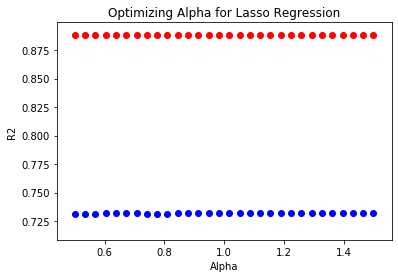

In [212]:
from sklearn.linear_model import Lasso #### try alphas; check adj R^2
a = .05
results = []

for a in np.linspace(.5, 1.5, num=30):
    Lassoreg = Lasso(alpha= a, max_iter = 1000000000, normalize = False)
    Lassoreg.fit(X, y)
    L_target_prediction = Lassoreg.predict(X_test)
    lassCoef = Lassoreg.coef_
    
    count = 0
    
    for i in Lassoreg.coef_: ### If the coef is significantly small the term is considered removed
        if abs(i) < .01:
            count += 1       ### Here is the numver of terms removed
    
    R2 = Lassoreg.score(X, y)
    n = len(X)
    k = len(X.columns) - count     ### here the original number of terms is subtracted by the insignificant terms
    adjR2 = R2 - ((n - 1)/(n - k)) * (1 - R2)
    
    results.append((a, R2, adjR2))

    plt.scatter(x=a, y = adjR2, c='b')
    plt.scatter(x=a, y = R2, c='r')
    plt.xlabel('Alpha')
    plt.ylabel('R2')
    plt.title('Optimizing Alpha for Lasso Regression')
results   
    #print(f'Adjusted R2: {adjR2}')

# Final model - Incorperating all the data for the best model

In [213]:
Lassoreg = Lasso(alpha= .845, max_iter = 1000000000, normalize = False)
Lassoreg.fit(X, y)
L_target_prediction = Lassoreg.predict(X)
lassCoef = Lassoreg.coef_

count = 0
for i in Lassoreg.coef_:
    if abs(i) < .01:
        count += 1
    
R2 = Lassoreg.score(X, y)
n = len(X)
k = len(X.columns) - count
adjR2 = R2 - ((n - 1)/(n - k)) * (1 - R2)
rmse = (mean_squared_error(y, L_target_prediction))**.5

print(f'rmse: {rmse}')
print(f'saleprice mean: {y.SalePrice.mean()}')
print(f'Adjusted R2: {adjR2}') 
print(f'R2: {Lassoreg.score(X, y)}')

rmse: 23717.64270306713
saleprice mean: 180373.88375558867
Adjusted R2: 0.7319021333025424
R2: 0.8880982817262786


In [214]:
coef_col =  {}

for i in range(len(Lassoreg.coef_)):
    coef_col[Lassoreg.coef_[i]] =  train_combined.columns[i] 
for key in sorted(coef_col.keys()):
    print(f'{key}, {coef_col[key]}')

-98102.18036616991, ThreeSsnPorch
-92681.36347041662, BedroomAbvGr_5
-85451.04172615249, BedroomAbvGr_6
-84565.52365428804, Functional_Sev
-83541.69625966609, Condition2_PosN
-74601.62838894122, Fireplaces_3
-59657.077438151246, LotConfig_FR3
-56509.22594031516, BedroomAbvGr_3
-52344.241611673344, BedroomAbvGr_4
-48749.27273588558, BedroomAbvGr_2
-48250.342900427066, BldgType_Twnhs
-43545.16675955693, RoofMatl_Membran
-37114.898179335825, BedroomAbvGr_1
-30444.570153562996, Foundation_Slab
-26131.606011770982, Neighborhood_MeadowV
-25727.35918239295, BldgType_TwnhsE
-24452.181360689385, Condition2_Feedr
-22461.00345572984, RoofStyle_Gable
-21786.62019741135, Neighborhood_OldTown
-21611.28274214255, Exterior1st_Stone
-20318.311182195, Neighborhood_IDOTRR
-18873.748729960644, SaleType_ConLD
-17722.187764906852, HouseStyle_2Story
-17700.404117333896, Functional_Maj2
-16088.14357640723, Neighborhood_Edwards
-15368.64694970797, HouseStyle_2_5Unf
-14366.588338821983, RoofStyle_Mansard
-14032

## Confirming Assumptions are upheld

### No Collinearity between features

In [696]:
test_colinear(train_combined)

[]

In [697]:
corr_saleprice = {}
for i, k in test_colinear(train_combined):
    corr_saleprice[i] = train_combined[f'{i}'].corr(targetdf['SalePrice'])
    corr_saleprice[k] = train_combined[f'{k}'].corr(targetdf['SalePrice'])
corr_saleprice

{}

### Normal distribution of residual: Q-Q plot

In [699]:
residuals = L_target_prediction - y.SalePrice

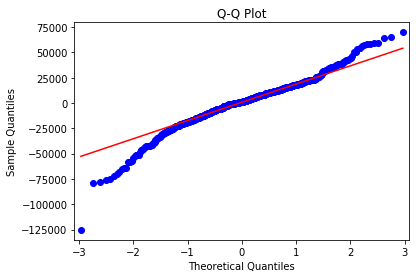

In [700]:
from statsmodels.graphics.gofplots import qqplot
qqplot(residuals, line='q');
plt.title('Q-Q Plot');

### Homoscedasticity:

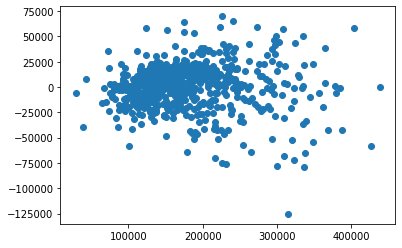

In [701]:
plt.scatter(x = L_target_prediction, y = residuals);

### No AutoCorrelation

#### Durbin-Watson Test

In [702]:
import statsmodels.stats.stattools as stools
stools.durbin_watson(residuals)


2.156403685486642

Value is extremely close to 2, by definition a value of 2 means there is no auto correlation.

### Implementation of XGBoost


In [704]:
import xgboost
from xgboost import plot_importance
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

In [718]:
XGBoost = XGBRegressor(max_depth=20, )
XGBoost.fit(X_train, y_train,)

y_pred = XGBoost.predict(X_test)
XGBoost_mse = mean_squared_error(y_test, y_pred)
print(np.sqrt(XGBoost_mse))

XGBoostError: [19:01:52] src/objective/objective.cc:23: Unknown objective function rmse
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000012ec6d579 dmlc::LogMessageFatal::~LogMessageFatal() + 57
  [bt] (1) 2   libxgboost.dylib                    0x000000012ecf424d xgboost::ObjFunction::Create(std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> > const&) + 541
  [bt] (2) 3   libxgboost.dylib                    0x000000012ec72b0a xgboost::LearnerImpl::LazyInitModel() + 1402
  [bt] (3) 4   libxgboost.dylib                    0x000000012ec882fe XGBoosterUpdateOneIter + 158
  [bt] (4) 5   libffi.6.dylib                      0x0000000106253884 ffi_call_unix64 + 76
  [bt] (5) 6   ???                                 0x00007ffeeb53d7a0 0x0 + 140732846561184

